# Chapter 5 – Support Vector Machines


First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Large margin classification (Linear SVM Classification)

The fundamental idea behind SVMs is best explained with some pictures. Figure 5-1 shows part of the iris dataset that was introduced at the end of Chapter 4. The two classes can clearly be separated easily with a straight line (they are linearly separable). The left plot shows the decision boundaries of three possible linear classifiers. The model whose decision boundary is represented by the dashed line is so bad that it does not even separate the classes properly. The other two models work perfectly on this training set, but their decision boundaries come so close to the instances that these models will probably not perform as well on new instances. In contrast, the solid line in the plot on the right represents the decision boundary of an SVM classifier; this line not only separates the two classes but also stays as far away from the closest training instances as possible. You can think of an SVM classifier as fitting the widest possible street (represented by the parallel dashed lines) between the classes. This is called *large margin classification*.

In [2]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [3]:
svm_clf.coef_, svm_clf.coef_.shape, svm_clf.coef_[0], svm_clf.coef_[0].shape

(array([[1.29411744, 0.82352928]]),
 (1, 2),
 array([1.29411744, 0.82352928]),
 (2,))

In [4]:
svm_clf.intercept_, svm_clf.intercept_[0]

(array([-3.78823471]), -3.7882347112962464)

In [5]:
svm_clf.predict([[5.5,1.7]])

array([1])

Saving figure large_margin_classification_plot


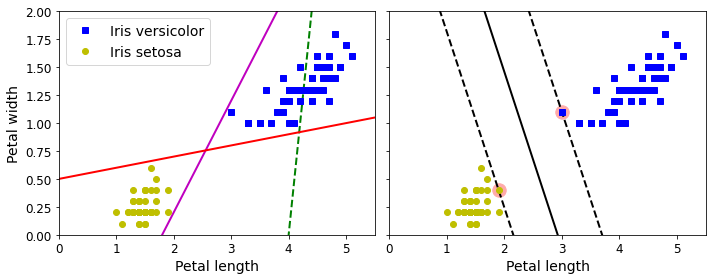

In [6]:
# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

save_fig("large_margin_classification_plot")
plt.show()

Figure 5-1. Large margin classification

Notice that adding more training instances “off the street” will not affect the decision boundary at all: it is fully determined (or “supported”) by the instances located on the edge of the street. These instances are called the support vectors (they are circled in Figure 5-1).

>WARNING  
>SVMs are sensitive to the feature scales, as you can see in Figure 5-2: in the left plot, the vertical scale is much larger than the horizontal scale, so the widest possible street is close to horizontal. After feature scaling (e.g., using Scikit-Learn’s StandardScaler), the decision boundary in the right plot looks much better.

Saving figure sensitivity_to_feature_scales_plot


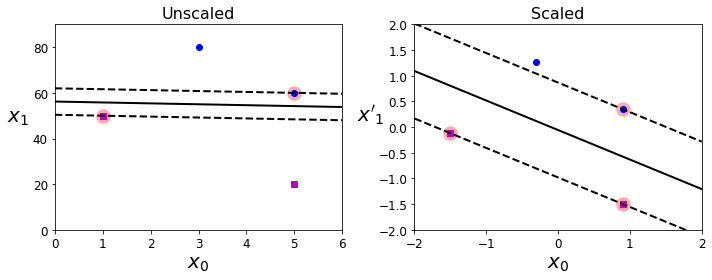

In [7]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

save_fig("sensitivity_to_feature_scales_plot")


Figure 5-2. Sensitivity to feature scales

**Soft Margin Classification** 

If we strictly impose that all instances must be off the street and on the right side, this is called *hard margin classification*. There are two main issues with hard margin classification. First, it only works if the data is linearly separable. Second, it is sensitive to outliers. Figure 5-3 shows the iris dataset with just one additional outlier: on the left, it is impossible to find a hard margin; on the right, the decision boundary ends up very different from the one we saw in Figure 5-1 without the outlier, and it will probably not generalize as well.

Saving figure sensitivity_to_outliers_plot


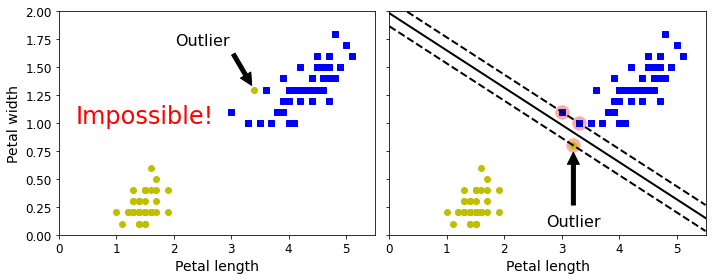

In [8]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

save_fig("sensitivity_to_outliers_plot")
plt.show()

Figure 5-3. Hard margin sensitivity to outliers

To avoid these issues, use a more flexible model. The objective is to find a good balance between keeping the street as large as possible and limiting the margin violations (i.e., instances that end up in the middle of the street or even on the wrong side). This is called *soft margin classification*.

When creating an SVM model using Scikit-Learn, we can specify a number of hyperparameters. `C` is one of those hyperparameters. If we set it to a low value, then we end up with the model on the left of Figure 5-4. With a high value, we get the model on the right. Margin violations are bad. It’s usually better to have few of them. However, in this case the model on the left has a lot of margin violations but will probably generalize better.

>TIP  
>If your SVM model is overfitting, you can try regularizing it by reducing `C`.

The following Scikit-Learn code loads the iris dataset, scales the features, and then trains a linear SVM model (using the `LinearSVC` class with `C=1` and the *hinge loss* function, described shortly) to detect *Iris virginica* flowers:

In [9]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [10]:
X[0:3], y[0:3]

(array([[1.4, 0.2],
        [1.4, 0.2],
        [1.3, 0.2]]),
 array([0., 0., 0.]))

In [11]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

Now let's generate the graph comparing different regularization settings:

In [12]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42, max_iter = 5000)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42, max_iter = 5000)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=100, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=5000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [13]:
# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

Saving figure regularization_plot


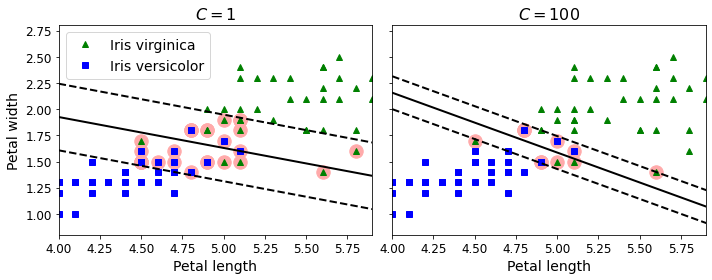

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

save_fig("regularization_plot")

Figure 5-4. Large margin (left) versus fewer margin violations (right)

>NOTE  
>Unlike Logistic Regression classifiers, SVM classifiers do not output probabilities for each class.

Instead of using the `LinearSVC` class, we could use the `SVC` class with a linear kernel. When creating the SVC model, we would write `SVC(kernel="linear", C=1)`. Or we could use the `SGDClassifier` class, with `SGDClassifier(loss="hinge", alpha=1/(m*C))`. This applies regular Stochastic Gradient Descent (see Chapter 4) to train a linear SVM classifier. It does not converge as fast as the `LinearSVC` class, but it can be useful to handle online classification tasks or huge datasets that do not fit in memory (out-of-core training).

>TIP  
>The `LinearSVC` class regularizes the bias term, so you should center the training set first by subtracting its mean. This is automatic if you scale the data using the `StandardScaler`. Also make sure you set the `loss` hyperparameter to `"hinge"`, as it is not the default value. Finally, for better performance, you should set the `dual` hyperparameter to `False`, unless there are more features than training instances (we will discuss duality later in the chapter).

## Non-linear classification

Although linear SVM classifiers are efficient and work surprisingly well in many cases, many datasets are not even close to being linearly separable. One approach to handling nonlinear datasets is to add more features, such as polynomial features (as you did in Chapter 4); in some cases this can result in a linearly separable dataset. Consider the left plot in Figure 5-5: it represents a simple dataset with just one feature, $x_1$. This dataset is not linearly separable, as you can see. But if you add a second feature $x_2 = (x_1)^2$, the resulting 2D dataset is perfectly linearly separable.

In [15]:
np.linspace(-4, 4, 9)

array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])

Saving figure higher_dimensions_plot


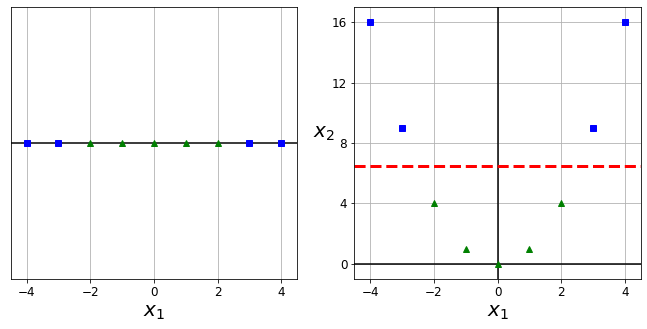

In [16]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$  ", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

save_fig("higher_dimensions_plot", tight_layout=False)
plt.show()

Figure 5-5. Adding features to make a dataset linearly separable

To implement this idea using Scikit-Learn, create a `Pipeline` containing a `PolynomialFeatures` transformer (discussed in “Polynomial Regression”), followed by a `StandardScaler` and a `LinearSVC`. Let’s test this on the moons dataset: this is a toy dataset for binary classification in which the data points are shaped as two interleaving half circles (see Figure 5-6). You can generate this dataset using the `make_moons()` function:

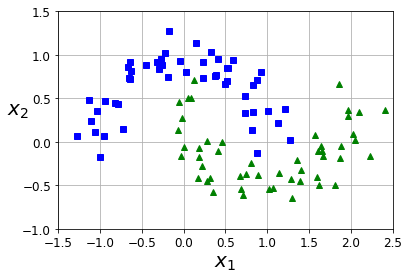

In [17]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [18]:
X[0:3], y[0:3], X.shape, y.shape

(array([[ 1.61383833, -0.49115086],
        [ 0.08984723,  0.50439056],
        [ 0.74721047, -0.36911116]]),
 array([1, 1, 1]),
 (100, 2),
 (100,))

In [19]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42, max_iter = 5000))
    ])

polynomial_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 LinearSVC(C=10, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=5000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [20]:
np.meshgrid(np.linspace(0, 1, 5), np.linspace(0, 1, 6))

[array([[0.  , 0.25, 0.5 , 0.75, 1.  ],
        [0.  , 0.25, 0.5 , 0.75, 1.  ],
        [0.  , 0.25, 0.5 , 0.75, 1.  ],
        [0.  , 0.25, 0.5 , 0.75, 1.  ],
        [0.  , 0.25, 0.5 , 0.75, 1.  ],
        [0.  , 0.25, 0.5 , 0.75, 1.  ]]),
 array([[0. , 0. , 0. , 0. , 0. ],
        [0.2, 0.2, 0.2, 0.2, 0.2],
        [0.4, 0.4, 0.4, 0.4, 0.4],
        [0.6, 0.6, 0.6, 0.6, 0.6],
        [0.8, 0.8, 0.8, 0.8, 0.8],
        [1. , 1. , 1. , 1. , 1. ]])]

Saving figure moons_polynomial_svc_plot


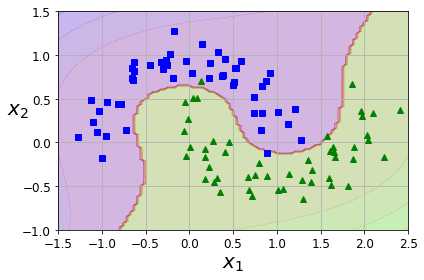

In [21]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

Figure 5-6. Linear SVM classifier using polynomial features

**Polynomial Kernel** 

Adding polynomial features is simple to implement and can work great with all sorts of Machine Learning algorithms (not just SVMs). That said, at a low polynomial degree, this method cannot deal with very complex datasets, and with a high polynomial degree it creates a huge number of features, making the model too slow.

Fortunately, when using SVMs you can apply an almost miraculous mathematical technique called the *kernel trick* (explained in a moment). The kernel trick makes it possible to get the same result as if you had added many polynomial features, even with very high-degree polynomials, without actually having to add them. So there is no combinatorial explosion of the number of features because you don’t actually add any features. This trick is implemented by the SVC class. Let’s test it on the moons dataset:

In [22]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=1, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [23]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=100, decision_function_shape='ovr', degree=10,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

This code trains an SVM classifier using a third-degree polynomial kernel. It is represented on the left in Figure 5-7. On the right is another SVM classifier using a 10th-degree polynomial kernel. Obviously, if your model is overfitting, you might want to reduce the polynomial degree. Conversely, if it is underfitting, you can try increasing it. The hyperparameter `coef0` controls how much the model is influenced by high-degree polynomials versus low-degree polynomials.

Saving figure moons_kernelized_polynomial_svc_plot


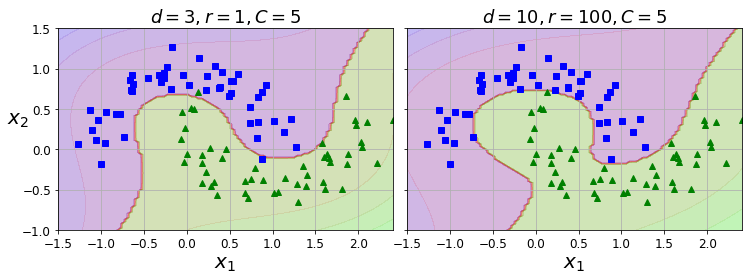

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

Figure 5-7. SVM classifiers with a polynomial kernel

>TIP  
>A common approach to finding the right hyperparameter values is to use grid search (see Chapter 2). It is often faster to first do a very coarse grid search, then a finer grid search around the best values found. Having a good sense of what each hyperparameter actually does can also help you search in the right part of the hyperparameter space.

**Similarity Features**  

Another technique to tackle nonlinear problems is to add features computed using a *similarity function*, which measures how much each instance resembles a particular landmark. For example, let’s take the 1D dataset discussed earlier and add two landmarks to it at $x_1 = –2$ and $x_1 = 1$ (see the left plot in Figure 5-8). Next, let’s define the similarity function to be the *Gaussian Radial Basis Function (RBF)* with $\gamma = 0.3$ (see Equation 5-1).

*Equation 5-1. Gaussian RBF*
$$\phi_{\gamma}(\mathbf x,\ell)=\exp(−\gamma\lVert \mathbf x−\ell\rVert^2)$$ 


This is a bell-shaped function varying from 0 (very far away from the landmark) to 1 (at the landmark). Now we are ready to compute the new features. For example, let’s look at the instance $x_1 = –1$: it is located at a distance of 1 from the first landmark and 2 from the second landmark. Therefore its new features are $x_2 = \exp(–0.3 \times 1^2) \approx 0.74$ and $x_3 = \exp(–0.3 \times 2^2) \approx 0.30$. The plot on the right in Figure 5-8 shows the transformed dataset (dropping the original features). As you can see, it is now linearly separable.

In [25]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

Saving figure kernel_method_plot


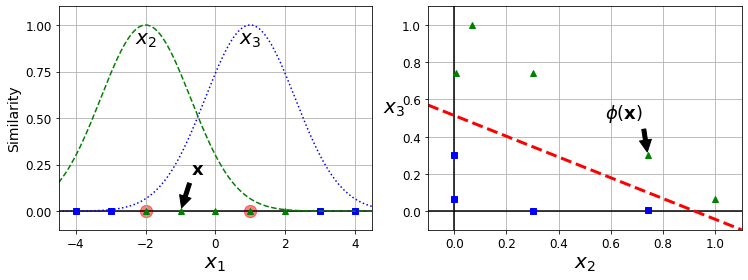

In [26]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

Figure 5-8. Similarity features using the Gaussian RBF

You may wonder how to select the landmarks. The simplest approach is to create a landmark at the location of each and every instance in the dataset. Doing that creates many dimensions and thus increases the chances that the transformed training set will be linearly separable. The downside is that a training set with m instances and n features gets transformed into a training set with m instances and m features (assuming you drop the original features). If your training set is very large, you end up with an equally large number of features.

**Gaussian RBF Kernel** 

Just like the polynomial features method, the similarity features method can be useful with any Machine Learning algorithm, but it may be computationally expensive to compute all the additional features, especially on large training sets. Once again the kernel trick does its SVM magic, making it possible to obtain a similar result as if you had added many similarity features. Let’s try the `SVC` class with the Gaussian RBF kernel:

In [27]:
X1D, X1D[3, 0]

(array([[-4.],
        [-3.],
        [-2.],
        [-1.],
        [ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.]]),
 -1.0)

In [28]:
x1_example = X1D[3, 0]
for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))

Phi(-1.0, -2) = [0.74081822]
Phi(-1.0, 1) = [0.30119421]


In [30]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

In [31]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])

rbf_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=0.001, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=5,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

This model is represented at the bottom left in Figure 5-9. The other plots show models trained with different values of hyperparameters `gamma` ($\gamma$) and `C`. Increasing `gamma` makes the bell-shaped curve narrower (see the lefthand plots in Figure 5-8). As a result, each instance’s range of influence is smaller: the decision boundary ends up being more irregular, wiggling around individual instances. Conversely, a small `gamma` value makes the bell-shaped curve wider: instances have a larger range of influence, and the decision boundary ends up smoother. So `gamma` acts like a regularization hyperparameter: if your model is overfitting, you should reduce it; if it is underfitting, you should increase it (similar to the `C` hyperparameter).

Saving figure moons_rbf_svc_plot


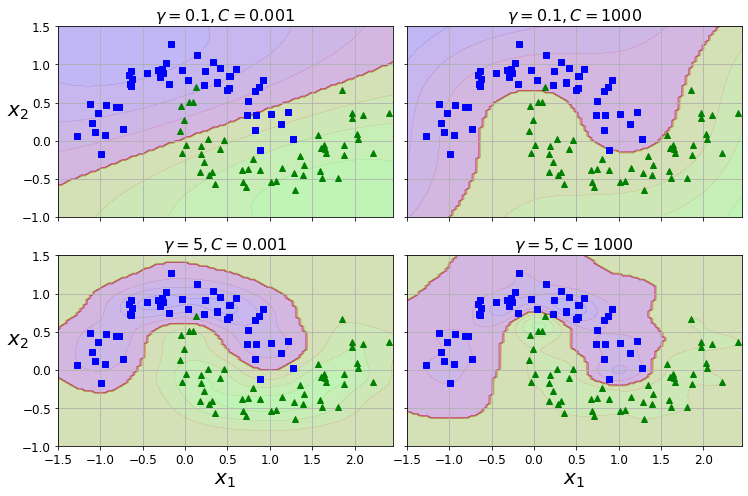

In [32]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2]) # Set the current Axes to ax and the current Figure to the parent of ax.
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

Figure 5-9. SVM classifiers using an RBF kernel

Other kernels exist but are used much more rarely. Some kernels are specialized for specific data structures. String kernels are sometimes used when classifying text documents or DNA sequences (e.g., using the string *subsequence kernel* or kernels based on the *Levenshtein distance*).

>TIP  
>With so many kernels to choose from, how can you decide which one to use? As a rule of thumb, you should always try the linear kernel first (remember that `LinearSVC` is much faster than `SVC(kernel="linear")`), especially if the training set is very large or if it has plenty of features. If the training set is not too large, you should also try the Gaussian RBF kernel; it works well in most cases. Then if you have spare time and computing power, you can experiment with a few other kernels, using cross-validation and grid search. You’d want to experiment like that especially if there are kernels specialized for your training set’s data structure.

**Computational Complexity** 

The `LinearSVC` class is based on the `liblinear` library, which implements an optimized algorithm for linear SVMs. It does not support the kernel trick, but it scales almost linearly with the number of training instances and the number of features. Its training time complexity is roughly $O(m \times n)$.

The algorithm takes longer if you require very high precision. This is controlled by the tolerance hyperparameter $\epsilon$ (called `tol` in Scikit-Learn). In most classification tasks, the default tolerance is fine.

The `SVC` class is based on the `libsvm` library, which implements an algorithm that supports the kernel trick. The training time complexity is usually between $O(m^2 \times n)$ and $O(m^3 \times n)$. Unfortunately, this means that it gets dreadfully slow when the number of training instances gets large (e.g., hundreds of thousands of instances). This algorithm is perfect for complex small or medium-sized training sets. It scales well with the number of features, especially with sparse features (i.e., when each instance has few nonzero features). In this case, the algorithm scales roughly with the average number of nonzero features per instance. Table 5-1 compares Scikit-Learn’s SVM classification classes. 

*Table 5-1. Comparison of Scikit-Learn classes for SVM classification*

| Class | Time complexity | Out-of-core support | Scaling required | Kernel trick |
| ---: | :--------- | :--- |  :--- | :--- | 
| `LinearSVC` | $O(m \times n)$    | No | Yes | No |
| `SGDClassifier` | $O(m \times n)$    | Yes | Yes | No |
| `SVC` | $O(m^2 \times n)\to O(m^3 \times n)$    | No | Yes | Yes |

## SVM Regression

As mentioned earlier, the SVM algorithm is versatile: not only does it support linear and nonlinear classification, but it also supports linear and nonlinear regression. To use SVMs for regression instead of classification, the trick is to reverse the objective: instead of trying to fit the largest possible street between two classes while limiting margin violations, SVM Regression tries to fit as many instances as possible on the street while limiting margin violations (i.e., instances off the street). The width of the street is controlled by a hyperparameter, $\epsilon$. Figure 5-10 shows two linear SVM Regression models trained on some random linear data, one with a large margin ($\epsilon$ = 1.5) and the other with a small margin ($\epsilon$ = 0.5).

In [33]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [37]:
X.shape, y.shape

((50, 1), (50,))

In [34]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=42, tol=0.0001, verbose=0)

In [38]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

In [41]:
svm_reg1.support_.shape, svm_reg2.support_.shape

((8, 1), (26, 1))

In [42]:
eps_y_pred

array([6.52640746])

Saving figure svm_regression_plot


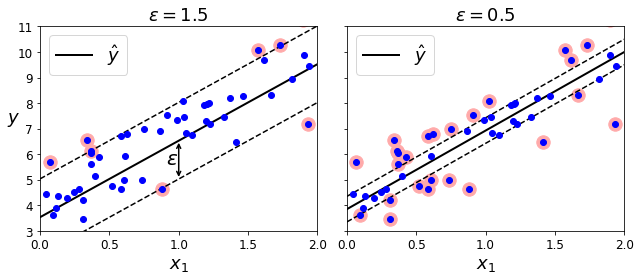

In [36]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
save_fig("svm_regression_plot")
plt.show()

Figure 5-10. SVM Regression

Adding more training instances within the margin does not affect the model’s predictions; thus, the model is said to be *$\epsilon$-insensitive*.

You can use Scikit-Learn’s `LinearSVR` class to perform linear SVM Regression. The following code produces the model represented on the left in Figure 5-10 (the training data should be scaled and centered first):

In [43]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

To tackle nonlinear regression tasks, you can use a kernelized SVM model. Figure 5-11 shows SVM Regression on a random quadratic training set, using a second-degree polynomial kernel. There is little regularization in the left plot (i.e., a large `C` value), and much more regularization in the right plot (i.e., a small `C` value).

The following code uses Scikit-Learn’s SVR class (which supports the kernel trick) to produce the model represented on the left in Figure 5-11:

**Note**: to be future-proof, we set `gamma="scale"`, as this will be the default value in Scikit-Learn 0.22.

In [44]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [45]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Saving figure svm_with_polynomial_kernel_plot


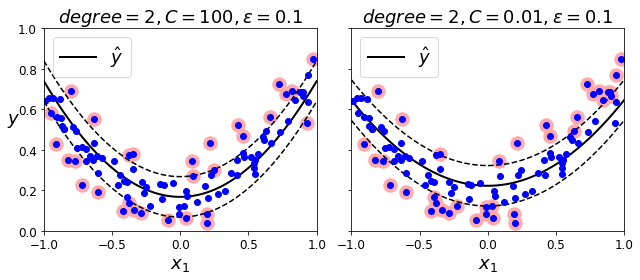

In [46]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

Figure 5-11. SVM Regression using a second-degree polynomial kernel

The SVR class is the regression equivalent of the SVC class, and the LinearSVR class is the regression equivalent of the LinearSVC class. The LinearSVR class scales linearly with the size of the training set (just like the LinearSVC class), while the SVR class gets much too slow when the training set grows large (just like the SVC class).

## Under the hood

This section explains how SVMs make predictions and how their training algorithms work, starting with linear SVM classifiers. If you are just getting started with Machine Learning, you can safely skip it and go straight to the exercises at the end of this chapter, and come back later when you want to get a deeper understanding of SVMs.

First, a word about notations. In Chapter 4 we used the convention of putting all the model parameters in one vector $\boldsymbol\theta$, including the bias term $\theta_0$ and the input feature weights $\theta_1$ to $\theta_n$, and adding a bias input $x_0 = 1$ to all instances. In this chapter we will use a convention that is more convenient (and more common) when dealing with SVMs: the bias term will be called *b*, and the feature weights vector will be called $\mathbf w$. No bias feature will be added to the input feature vectors.

**Decision Function and Predictions** 

The linear SVM classifier model predicts the class of a new instance $\mathbf x$ by simply computing the decision function $$\mathbf w^T \mathbf x + b = w_1 x_1 + \cdots + w_n x_n + b$$. If the result is positive, the predicted class $\hat y$ is the positive class (1), and otherwise it is the negative class (0); see Equation 5-2.

*Equation 5-2. Linear SVM classifier prediction* 

$$\hat y=\begin{cases}
0 & \text{ if } \mathbf w^T \mathbf x + b <0 \\
1 & \text{ if } \mathbf w^T \mathbf x + b \ge 0 \\
\end{cases}$$

Figure 5-12 shows the decision function that corresponds to the model in the left in Figure 5-4: it is a 2D plane because this dataset has two features (petal width and petal length). The decision boundary is the set of points where the decision function is equal to 0: it is the intersection of two planes, which is a straight line (represented by the thick solid line).

In [47]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

Saving figure iris_3D_plot


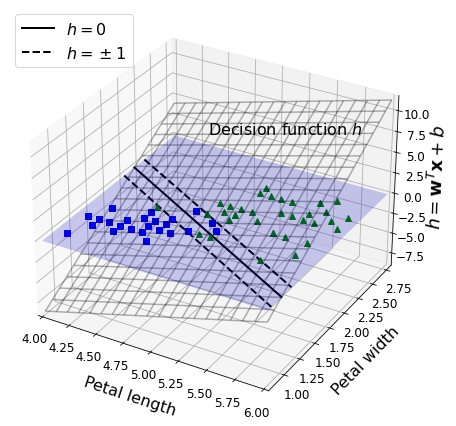

In [48]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=16)
    ax.set_xlabel(r"Petal length", fontsize=16, labelpad=10)
    ax.set_ylabel(r"Petal width", fontsize=16, labelpad=10)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18, labelpad=5)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])

save_fig("iris_3D_plot")
plt.show()

Figure 5-12. Decision function for the iris dataset

The dashed lines represent the points where the decision function is equal to 1 or –1: they are parallel and at equal distance to the decision boundary, and they form a margin around it. Training a linear SVM classifier means finding the values of $\mathbf w$ and $b$ that make this margin as wide as possible while avoiding margin violations (hard margin) or limiting them (soft margin).

**Training Objective** 

Consider the slope of the decision function: it is equal to the norm of the weight vector, $\lVert \mathbf w \rVert$. If we divide this slope by 2, the points where the decision function is equal to ±1 are going to be twice as far away from the decision boundary. In other words, dividing the slope by 2 will multiply the margin by 2. This may be easier to visualize in 2D, as shown in Figure 5-13. The smaller the weight vector $\mathbf w$, the larger the margin.

Saving figure small_w_large_margin_plot


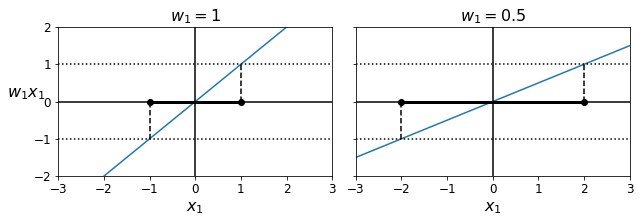

In [49]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")
    plt.plot(x1_lim, [-1, -1], "k:")
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot([m, m], [0, 1], "k--")
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

fig, axes = plt.subplots(ncols=2, figsize=(9, 3.2), sharey=True)
plt.sca(axes[0])
plot_2D_decision_function(1, 0)
plt.sca(axes[1])
plot_2D_decision_function(0.5, 0, ylabel=False)
save_fig("small_w_large_margin_plot")
plt.show()

Figure 5-13. A smaller weight vector results in a larger margin

So we want to minimize $\lVert \mathbf w \rVert$ to get a large margin. If we also want to avoid any margin violations (hard margin), then we need the decision function to be greater than 1 for all positive training instances and lower than –1 for negative training instances. If we define $t^{(i)} = –1$ for negative instances (if $y^{(i)} = 0$) and $t^{(i)} = 1$ for positive instances (if $y^{(i)} = 1$), then we can express this constraint as $t^{(i)}(\mathbf w^T \mathbf x^{(i)} + b) \ge 1$ for all instances.

We can therefore express the hard margin linear SVM classifier objective as the constrained optimization problem in Equation 5-3.

*Equation 5-3. Hard margin linear SVM classifier objective*

$$\underset{\mathbf w, b}{\text{minimize}}\quad\frac{1}{2}\mathbf w^T\mathbf w$$
$$\text{subject to}\quad t^{(i)}(\mathbf w^T \mathbf x^{(i)} + b) \ge 1\quad \text{for }i=1,2,\cdots,m$$

>NOTE  
>We are minimizing $\frac{1}{2}\mathbf w^T\mathbf w$, which is equal to $\frac{1}{2}\lVert \mathbf w \rVert^2$, rather than minimizing $\lVert \mathbf w \rVert$. Indeed, $\frac{1}{2}\lVert \mathbf w \rVert^2$ has a nice, simple derivative (it is just $\mathbf w$), while $\lVert \mathbf w \rVert$ is not differentiable at $\mathbf w = 0$. Optimization algorithms work much better on differentiable functions.

To get the soft margin objective, we need to introduce a *slack variable*  $\zeta^{(i)} \ge 0$ for each instance: $\zeta^{(i)}$ measures how much the $i^{th}$ instance is allowed to violate the margin. We now have two conflicting objectives: make the *slack variables* as small as possible to reduce the margin violations, and make $\frac{1}{2}\mathbf w^T\mathbf w$ as small as possible to increase the margin. This is where the `C` hyperparameter comes in: it allows us to define the tradeoff between these two objectives. This gives us the constrained optimization problem in Equation 5-4.

*Equation 5-4. Soft margin linear SVM classifier objective*
$$\underset{\mathbf w, b,\zeta}{\text{minimize}}\quad\frac{1}{2}\mathbf w^T\mathbf w+C\sum_{i=1}^{m}\zeta^{(i)}$$
$$\text{subject to}\quad t^{(i)}(\mathbf w^T \mathbf x^{(i)} + b) \ge 1-\zeta^{(i)}\quad \text{and }\zeta^{(i)}\ge 0 \quad\text{for }i=1,2,\cdots,m$$

**Quadratic Programming**  

The hard margin and soft margin problems are both convex quadratic optimization problems with linear constraints. Such problems are known as *Quadratic Programming* (QP) problems. Many off-the-shelf solvers are available to solve QP problems by using a variety of techniques that are outside the scope of this book.

The general problem formulation is given by Equation 5-5.

*Equation 5-5. Quadratic Programming problem* 

$$\underset{\mathbf p}{\text{Minimize}}\quad\frac{1}{2}\underset{(n_p\times 1)}{\mathbf p}^T\underset{(n_p\times n_p)}{\mathbf H}\underset{(n_p\times 1)}{\mathbf p}+\underset{(n_p\times 1)}{\mathbf f}^T\underset{(n_p\times 1)}{\mathbf p}$$
$$\text{subject to}\quad \underset{(n_c\times n_p)}{\mathbf A}\underset{(n_p\times 1)}{\mathbf p}\le \underset{(n_c\times 1)}{\mathbf b}$$
$$\text{where }\quad \begin{cases}
\mathbf p & \text{is an } n_p-\text{dimensional vector }(n_p = \text{number of parameters})\\
\mathbf H & \text{is an } n_p\times n_p\text{ matrix}\\
\mathbf f & \text{is an } n_p-\text{dimensional vector }\\
\mathbf A & \text{is an } n_c\times n_p\text{ matrix }(n_c = \text{number of constraints})\\
\mathbf b & \text{is an } n_c-\text{dimensional vector }\\
\end{cases}$$

**The Dual Problem**  

Given a constrained optimization problem, known as the *primal problem*, it is possible to express a different but closely related problem, called its *dual problem*. The solution to the dual problem typically gives a lower bound to the solution of the primal problem, but under some conditions it can have the same solution as the primal problem. Luckily, the SVM problem happens to meet these conditions, so you can choose to solve the primal problem or the dual problem; both will have the same solution. Equation 5-6 shows the dual form of the linear SVM objective (if you are interested in knowing how to derive the dual problem from the primal problem, see Appendix C).

*Equation 5-6. Dual form of the linear SVM objective*  
$$\underset{\alpha}{\text{minimize}}\quad \frac{1}{2}\sum_{i=1}^{m}\sum_{j=1}^{m}\alpha^{(i)}\alpha^{(j)}t^{(i)}t^{(j)}{\mathbf x^{(i)}}^T\mathbf x^{(j)}-\sum_{i=1}^{m}\alpha^{(i)}$$
$$\text{subject to}\quad \alpha^{(i)}\ge 0 \quad\text{for } i=1,2,\cdots,m$$ 

Once you find the vector $\hat{\boldsymbol\alpha}$ that minimizes this equation (using a QP solver), use Equation 5-7 to compute $\hat{\mathbf w}$ and $\hat{b}$ that minimize the primal problem. 

*Equation 5-7. From the dual solution to the primal solution* 

$$\hat{\mathbf w}=\sum_{i=1}^{m}\hat{\alpha}^{(i)}t^{(i)}\hat{\mathbf x}^{(i)}$$
$$\hat{b}=\frac{1}{n_s}\underset{\hat{\alpha}^{(i)}>0}{\sum_{i=1}^{m}}\left(t^{(i)}-\hat{\mathbf w}^T\mathbf x^{(i)}\right)$$

The dual problem is faster to solve than the primal one when the number of training instances is smaller than the number of features. More importantly, the dual problem makes the kernel trick possible, while the primal does not. So what is this kernel trick, anyway?

In [50]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64) # Iris virginica

svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X, y)
svm_clf.predict([[5.3, 1.3]])

array([1.])

## Online SVMs 

Before concluding this chapter, let’s take a quick look at online SVM classifiers (recall that online learning means learning incrementally, typically as new instances arrive).

For linear SVM classifiers, one method for implementing an online SVM classifier is to use Gradient Descent (e.g., using `SGDClassifier`) to minimize the cost function in Equation 5-13, which is derived from the primal problem. Unfortunately, Gradient Descent converges much more slowly than the methods based on QP.

*Equation 5-13. Linear SVM classifier cost function*
$$J(\mathbf w, b)=\frac{1}{2}\mathbf w^T\mathbf w+C\sum_{i=1}^{m}\text{ max }\left(0, 1-t^{(i)}\left(\mathbf w^T\mathbf x^{(i)}+b\right)\right)$$ 

The first sum in the cost function will push the model to have a small weight vector $\mathbf w$, leading to a larger margin. The second sum computes the total of all margin violations. An instance’s margin violation is equal to $0$ if it is located off the street and on the correct side, or else it is proportional to the distance to the correct side of the street. Minimizing this term ensures that the model makes the margin violations as small and as few as possible.

**HINGE LOSS**  

The function $max(0, 1 – t)$ is called the hinge loss function (see the following image). It is equal to $0$ when $t \ge 1$. Its derivative (slope) is equal to $–1$ if $t < 1$ and $0$ if $t > 1$. It is not differentiable at $t = 1$, but just like for Lasso Regression (see “Lasso Regression”), you can still use Gradient Descent using any subderivative at $t = 1$ (i.e., any value between $–1$ and $0$).

Saving figure hinge_plot


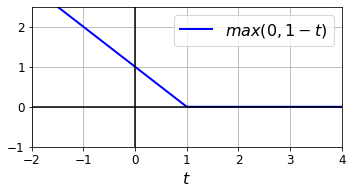

In [34]:
t = np.linspace(-2, 4, 200)
h = np.where(1 - t < 0, 0, 1 - t)  # max(0, 1-t)

plt.figure(figsize=(5,2.8))
plt.plot(t, h, "b-", linewidth=2, label="$max(0, 1 - t)$")
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.yticks(np.arange(-1, 2.5, 1))
plt.xlabel("$t$", fontsize=16)
plt.axis([-2, 4, -1, 2.5])
plt.legend(loc="upper right", fontsize=16)
save_fig("hinge_plot")
plt.show()

## Extra material

### Training time

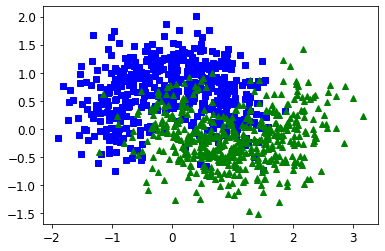

In [51]:
X, y = make_moons(n_samples=1000, noise=0.4, random_state=42)
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")

[LibSVM]0 0.1 0.30803751945495605
[LibSVM]1 0.01 0.3100857734680176
[LibSVM]2 0.001 0.3718252182006836
[LibSVM]3 0.0001 0.6667850017547607
[LibSVM]4 1e-05 1.1733663082122803
[LibSVM]5 1.0000000000000002e-06 1.0982229709625244
[LibSVM]6 1.0000000000000002e-07 8.699617147445679
[LibSVM]7 1.0000000000000002e-08 1.1521327495574951
[LibSVM]8 1.0000000000000003e-09 1.1602013111114502
[LibSVM]9 1.0000000000000003e-10 1.169257402420044


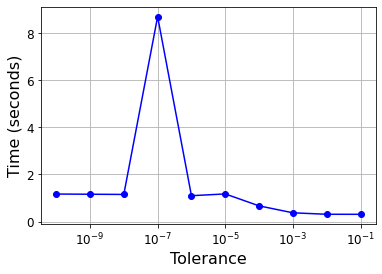

In [52]:
import time

tol = 0.1
tols = []
times = []
for i in range(10):
    svm_clf = SVC(kernel="poly", gamma=3, C=10, tol=tol, verbose=1)
    t1 = time.time()
    svm_clf.fit(X, y)
    t2 = time.time()
    times.append(t2-t1)
    tols.append(tol)
    print(i, tol, t2-t1)
    tol /= 10
plt.semilogx(tols, times, "bo-") # Make a plot with log scaling on the x axis.
plt.xlabel("Tolerance", fontsize=16)
plt.ylabel("Time (seconds)", fontsize=16)
plt.grid(True)
plt.show()

### Linear SVM classifier implementation using Batch Gradient Descent

In [53]:
# Training set
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64).reshape(-1, 1) # Iris virginica

In [54]:
from sklearn.base import BaseEstimator

class MyLinearSVC(BaseEstimator):
    def __init__(self, C=1, eta0=1, eta_d=10000, n_epochs=1000, random_state=None):
        self.C = C
        self.eta0 = eta0
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.eta_d = eta_d

    def eta(self, epoch):
        return self.eta0 / (epoch + self.eta_d)
        
    def fit(self, X, y):
        # Random initialization
        if self.random_state:
            np.random.seed(self.random_state)
        w = np.random.randn(X.shape[1], 1) # n feature weights
        b = 0

        m = len(X)
        t = y * 2 - 1  # -1 if y==0, +1 if y==1
        X_t = X * t
        self.Js=[]

        # Training
        for epoch in range(self.n_epochs):
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
            X_t_sv = X_t[support_vectors_idx]
            t_sv = t[support_vectors_idx]

            J = 1/2 * np.sum(w * w) + self.C * (np.sum(1 - X_t_sv.dot(w)) - b * np.sum(t_sv))
            self.Js.append(J)

            w_gradient_vector = w - self.C * np.sum(X_t_sv, axis=0).reshape(-1, 1)
            b_derivative = -C * np.sum(t_sv)
                
            w = w - self.eta(epoch) * w_gradient_vector
            b = b - self.eta(epoch) * b_derivative
            

        self.intercept_ = np.array([b])
        self.coef_ = np.array([w])
        support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return (self.decision_function(X) >= 0).astype(np.float64)

C=2
svm_clf = MyLinearSVC(C=C, eta0 = 10, eta_d = 1000, n_epochs=60000, random_state=2)
svm_clf.fit(X, y)
svm_clf.predict(np.array([[5, 2], [4, 1]]))

array([[1.],
       [0.]])

(0.0, 60000.0, 0.0, 100.0)

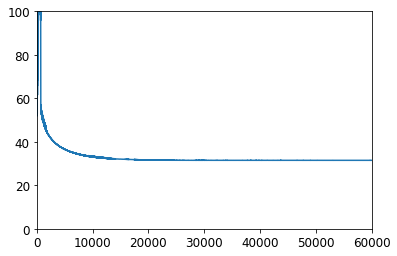

In [55]:
plt.plot(range(svm_clf.n_epochs), svm_clf.Js)
plt.axis([0, svm_clf.n_epochs, 0, 100])

In [56]:
print(svm_clf.intercept_, svm_clf.coef_)

[-15.56761653] [[[2.28120287]
  [2.71621742]]]


In [57]:
svm_clf2 = SVC(kernel="linear", C=C)
svm_clf2.fit(X, y.ravel())
print(svm_clf2.intercept_, svm_clf2.coef_)

[-15.51721253] [[2.27128546 2.71287145]]


(4.0, 6.0, 0.8, 2.8)

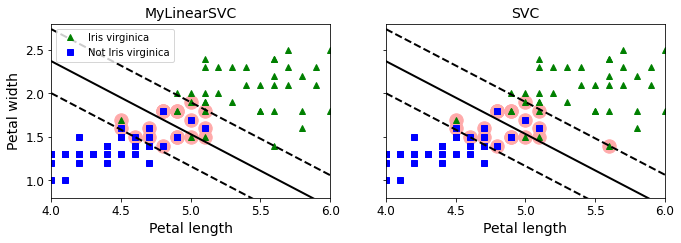

In [58]:
yr = y.ravel()
fig, axes = plt.subplots(ncols=2, figsize=(11, 3.2), sharey=True)
plt.sca(axes[0])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs", label="Not Iris virginica")
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("MyLinearSVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])
plt.legend(loc="upper left")

plt.sca(axes[1])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("SVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])

[-12.52988101   1.94162342   1.84544824]


(4.0, 6.0, 0.8, 2.8)

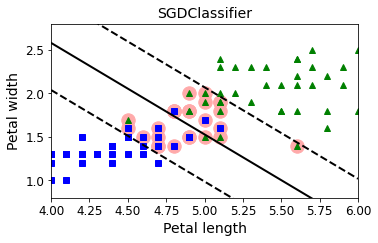

In [59]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="hinge", alpha=0.017, max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X, y.ravel())

m = len(X)
t = y * 2 - 1  # -1 if y==0, +1 if y==1
X_b = np.c_[np.ones((m, 1)), X]  # Add bias input x0=1
X_b_t = X_b * t
sgd_theta = np.r_[sgd_clf.intercept_[0], sgd_clf.coef_[0]]
print(sgd_theta)
support_vectors_idx = (X_b_t.dot(sgd_theta) < 1).ravel()
sgd_clf.support_vectors_ = X[support_vectors_idx]
sgd_clf.C = C

plt.figure(figsize=(5.5,3.2))
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(sgd_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("SGDClassifier", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])

## Exercises

1. What is the fundamental idea behind Support Vector Machines?  

>The fundamental idea behind Support Vector Machines is to fit the widest possible “street” between the classes. In other words, the goal is to have the largest possible margin between the decision boundary that separates the two classes and the training instances. When performing soft margin classification, the SVM searches for a compromise between perfectly separating the two classes and having the widest possible street (i.e., a few instances may end up on the street). Another key idea is to use kernels when training on nonlinear datasets.

2. What is a support vector?  

>After training an SVM, a support vector is any instance located on the “street” (see the previous answer), including its border. The decision boundary is entirely determined by the support vectors. Any instance that is not a support vector (i.e., is off the street) has no influence whatsoever; you could remove them, add more instances, or move them around, and as long as they stay off the street they won’t affect the decision boundary. Computing the predictions only involves the support vectors, not the whole training set.

3. Why is it important to scale the inputs when using SVMs?  

>SVMs try to fit the largest possible “street” between the classes (see the first answer), so if the training set is not scaled, the SVM will tend to neglect small features (see Figure 5-2).



4. Can an SVM classifier output a confidence score when it classifies an instance? What about a probability?  

>An SVM classifier can output the distance between the test instance and the decision boundary, and you can use this as a confidence score. However, this score cannot be directly converted into an estimation of the class probability. If you set probability=True when creating an SVM in Scikit-Learn, then after training it will calibrate the probabilities using Logistic Regression on the SVM’s scores (trained by an additional five-fold cross-validation on the training data). This will add the predict_proba() and predict_log_proba() methods to the SVM.

5. Should you use the primal or the dual form of the SVM problem to train a model on a training set with millions of instances and hundreds of features?  

>This question applies only to linear SVMs since kernelized SVMs can only use the dual form. The computational complexity of the primal form of the SVM problem is proportional to the number of training instances $m$, while the computational complexity of the dual form is proportional to a number between $m^2$ and $m^3$. So if there are millions of instances, you should definitely use the primal form, because the dual form will be much too slow.



6. Say you’ve trained an SVM classifier with an RBF kernel, but it seems to underfit the training set. Should you increase or decrease $\gamma$ (gamma)? What about `C`?  

>If an SVM classifier trained with an RBF kernel underfits the training set, there might be too much regularization. To decrease it, you need to increase `gamma` or `C` (or both).

7. How should you set the QP parameters (H, f, A, and b) to solve the soft margin linear SVM classifier problem using an off-the-shelf QP solver?

>Let’s call the QP parameters for the hard margin problem $\mathbf H'$, $\mathbf f'$, $\mathbf A'$, and $\mathbf b'$ (see “Quadratic Programming”). The QP parameters for the soft margin problem have $m$ additional parameters $(n_p = n + 1 + m)$ and $m$ additional constraints $(n_c = 2m)$. They can be defined like so:

> - $\mathbf H$ is equal to $\mathbf H'$, plus $m$ columns of $0s$ on the right and $m$ rows of $0s$ at the bottom: $$\mathbf H=\begin{cases}\mathbf H' & 0 & \cdots\\
0 & 0 & \cdots\\
\vdots & \vdots & \ddots\\
\end{cases}$$
> - $\mathbf f$ is equal to $\mathbf f'$ with $m$ additional elements, all equal to the value of the hyperparameter `C`.
> - $\mathbf b$ is equal to $\mathbf b'$ with $m$ additional elements, all equal to $0$.
> - $\mathbf A$ is equal to $\mathbf A'$, with an extra $m \times m$ identity matrix $\mathbf I_m$ appended to the right, $–{\mathbf I}_m$ just below it, and the rest filled with $0s$: $$\mathbf A = \begin{pmatrix}\mathbf A' & \mathbf I_m\\
\mathbf 0 & -\mathbf I_m\end{pmatrix}$$ 

8. Exercise: train a `LinearSVC` on a linearly separable dataset. Then train an `SVC` and a `SGDClassifier` on the same dataset. See if you can get them to produce roughly the same model._

Let's use the Iris dataset: the Iris Setosa and Iris Versicolor classes are linearly separable.

In [53]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [54]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 5
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha,
                        max_iter=1000, tol=1e-3, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

print("LinearSVC:                   ", lin_clf.intercept_, lin_clf.coef_)
print("SVC:                         ", svm_clf.intercept_, svm_clf.coef_)
print("SGDClassifier(alpha={:.5f}):".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_)

LinearSVC:                    [0.28475098] [[1.05364854 1.09903804]]
SVC:                          [0.31896852] [[1.1203284  1.02625193]]
SGDClassifier(alpha=0.00200): [0.117] [[0.77714169 0.72981762]]


Let's plot the decision boundaries of these three models:

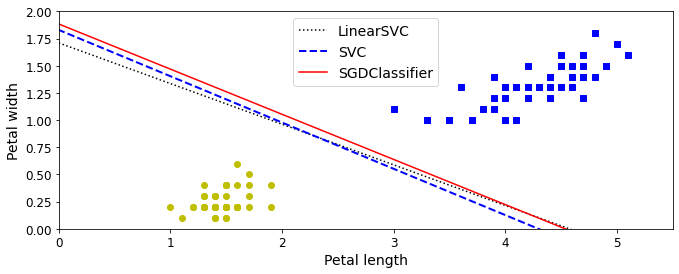

In [55]:
# Compute the slope and bias of each decision boundary
w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# Transform the decision boundary lines back to the original scale
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris setosa"
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

Close enough!

9. Train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you will need to use one-versus-the-rest to classify all 10 digits. You may want to tune the hyperparameters using small validation sets to speed up the process. What accuracy can you reach?


First, let's load the dataset and split it into a training set and a test set. We could use `train_test_split()` but people usually just take the first 60,000 instances for the training set, and the last 10,000 instances for the test set (this makes it possible to compare your model's performance with others): 

In [60]:
import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

Many training algorithms are sensitive to the order of the training instances, so it's generally good practice to shuffle them first. However, the dataset is already shuffled, so we do not need to do it.

Let's start simple, with a linear SVM classifier. It will automatically use the One-vs-All (also called One-vs-the-Rest, OvR) strategy, so there's nothing special we need to do. Easy!

**Warning**: this may take a few minutes depending on your hardware.

In [61]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

lin_clf = LinearSVC(max_iter = 5000, random_state=42)
lin_clf.fit(X_train, y_train)

/home/dan/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=5000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

Let's make predictions on the training set and measure the accuracy (we don't want to measure it on the test set yet, since we have not selected and trained the final model yet):

In [62]:
from sklearn.metrics import accuracy_score

y_pred = lin_clf.predict(X_train)
accuracy_score(y_train, y_pred)

0.8792166666666666

Okay, 87.9% accuracy on MNIST is pretty bad. This linear model is certainly too simple for MNIST, but perhaps we just needed to scale the data first:

In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

In [64]:
lin_clf = LinearSVC(max_iter = 10000, random_state=42)
lin_clf.fit(X_train_scaled, y_train)

/home/dan/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [65]:
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9272833333333333

That's much better (we cut the error rate by about 25%), but still not great at all for MNIST. If we want to use an SVM, we will have to use a kernel. Let's try an `SVC` with an RBF kernel (the default).

**Note**: to be future-proof we set `gamma="scale"` since it will be the default value in Scikit-Learn 0.22.

In [10]:
svm_clf = SVC(gamma="scale")
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

SVC()

In [11]:
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9455333333333333

That's promising, we get better performance even though we trained the model on 6 times less data. Let's tune the hyperparameters by doing a randomized search with cross validation. We will do this on a small dataset just to speed up the process:

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...C=4.989688283477207, gamma=0.0016943880417337597; total time=   0.2s
[CV] END ...C=4.989688283477207, gamma=0.0016943880417337597; total time=   0.2s
[CV] END ...C=4.989688283477207, gamma=0.0016943880417337597; total time=   0.2s
[CV] END ......C=2.816088566774382, gamma=0.0971062110527967; total time=   0.2s
[CV] END ......C=2.816088566774382, gamma=0.0971062110527967; total time=   0.2s
[CV] END ......C=2.816088566774382, gamma=0.0971062110527967; total time=   0.2s
[CV] END .....C=5.537304055094001, gamma=0.00635988617843593; total time=   0.2s
[CV] END .....C=5.537304055094001, gamma=0.00635988617843593; total time=   0.2s
[CV] END .....C=5.537304055094001, gamma=0.00635988617843593; total time=   0.2s
[CV] END .....C=2.190091652057308, gamma=0.07296382692148386; total time=   0.2s
[CV] END .....C=2.190091652057308, gamma=0.07296382692148386; total time=   0.2s
[CV] END .....C=2.190091652057308, gamma=0.07296

RandomizedSearchCV(cv=3, estimator=SVC(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f59efa94d90>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f59efa94d60>},
                   verbose=2)

In [13]:
rnd_search_cv.best_estimator_

SVC(C=4.989688283477207, gamma=0.0016943880417337597)

In [14]:
rnd_search_cv.best_score_

0.8609957262651874

This looks pretty low but remember we only trained the model on 1,000 instances. Let's retrain the best estimator on the whole training set (run this at night, it will take hours):

In [15]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=4.989688283477207, gamma=0.0016943880417337597)

In [16]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9987166666666667

Ah, this looks good! Let's select this model. Now we can test it on the test set:

In [17]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9713

Not too bad, but apparently the model is overfitting slightly. It's tempting to tweak the hyperparameters a bit more (e.g. decreasing `C` and/or `gamma`), but we would run the risk of overfitting the test set. Other people have found that the hyperparameters `C=5` and `gamma=0.005` yield even better performance (over 98% accuracy). By running the randomized search for longer and on a larger part of the training set, you may be able to find this as well.

10. Train an SVM regressor on the California housing dataset.

Let's load the dataset using Scikit-Learn's `fetch_california_housing()` function:

In [61]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

Split it into a training set and a test set:

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Don't forget to scale the data:

In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Let's train a simple `LinearSVR` first:

In [64]:
from sklearn.svm import LinearSVR

lin_svr = LinearSVR(max_iter = 5000, random_state=42)
lin_svr.fit(X_train_scaled, y_train)

/Users/ageron/miniconda3/envs/tf2b/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=42, tol=0.0001, verbose=0)

Let's see how it performs on the training set:

In [65]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
mse

0.954517044073374

Let's look at the RMSE:

In [66]:
np.sqrt(mse)

0.976993881287582

In this training set, the targets are tens of thousands of dollars. The RMSE gives a rough idea of the kind of error you should expect (with a higher weight for large errors): so with this model we can expect errors somewhere around $10,000. Not great. Let's see if we can do better with an RBF Kernel. We will use randomized search with cross validation to find the appropriate hyperparameter values for `C` and `gamma`:

In [67]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, cv=3, random_state=42)
rnd_search_cv.fit(X_train_scaled, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................
[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   5.4s
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s


[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   5.5s
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................
[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   5.5s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   5.3s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   5.2s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   5.1s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .. C=2.560186404424365, gamma=0.002051110418843397, total=   4.6s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .. C=2.560186404424365, gamma=0.002051110418843397, total=   4.6s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.5min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12fc2e390>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12fc2eac8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [68]:
rnd_search_cv.best_estimator_

SVR(C=4.745401188473625, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.07969454818643928, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

Now let's measure the RMSE on the training set:

In [69]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

0.5727524770785359

Looks much better than the linear model. Let's select this model and evaluate it on the test set:

In [70]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

0.5929168385528734